In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a954d91ba6b8bd790c9585705b7dfd66bd3b644ac900b0a3b6b11375b806ba0a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import numpy as np
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

2024-07-30 06:21:35.413120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 06:21:35.413254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 06:21:35.540008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Loading the dataset
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [4]:
# Define updated preprocessing function for a specific tokenizer
def preprocess_function(examples, tokenizer, max_input_length=128, max_target_length=512):
    """Tokenize the text and set the labels"""
    # Tokenize the questions
    inputs = tokenizer(examples["question"], max_length=max_input_length, truncation=True, padding='max_length')
    
    # Tokenize the answers
    labels = tokenizer(text_target=examples["answer"], max_length=max_target_length, truncation=True, padding='max_length')
    
    inputs["labels"] = labels["input_ids"]
    return inputs

# Load the tokenizer for each model
tokenizers = {
    'bert': AutoTokenizer.from_pretrained('google-bert/bert-large-uncased-whole-word-masking-finetuned-squad'),
    'flan_t5': AutoTokenizer.from_pretrained('sjrhuschlee/flan-t5-base-squad2'),
    'gpt2': AutoTokenizer.from_pretrained('anas-awadalla/gpt2-span-head-few-shot-k-16-finetuned-squad-seed-0')
}

# Apply preprocessing for each tokenizer
tokenized_dfs = {}
for model_name, tokenizer in tokenizers.items():
    tokenized_data = df.apply(lambda x: preprocess_function({"question": x['question'], "answer": x['answer']}, tokenizer), axis=1)
    tokenized_dfs[model_name] = pd.DataFrame(list(tokenized_data))

# Display a preview of one tokenized dataframe
tokenized_dfs['bert'].head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

,attention_mask,input_ids,labels,token_type_ids
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2339, 7188, 1045, 2131, 1999, 1996, 6457...","[101, 3475, 1521, 1056, 2009, 9643, 1029, 2017...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[101, 2054, 2003, 1037, 24540, 1010, 1998, 212...","[101, 1037, 24540, 8241, 2003, 1037, 2291, 203...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2054, 2299, 2038, 1996, 4581, 1000, 2619...","[101, 17719, 1005, 1055, 2380, 102, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 1045, 2572, 1996, 3954, 1997, 2019, 4639...","[101, 2123, 1005, 1056, 2292, 18726, 2008, 202...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2515, 1996, 6331, 5254, 2505, 2055, 1037...","[101, 2358, 1012, 2198, 1999, 1996, 2338, 1997...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
# Defining model names
models = {
    'bert': 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad',
    'flan_t5': 'sjrhuschlee/flan-t5-base-squad2',
    'gpt2': 'anas-awadalla/gpt2-span-head-few-shot-k-16-finetuned-squad-seed-0'
}

# Initializing models and tokenizers
pipelines = {}
for name, model_name in models.items():
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer, device=0)
    pipelines[name] = qa_pipeline

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
# Function to get answers with error handling
def get_answer(row, model_name):
    question = row['question']
    context = row['answer']
    if not question or not context:
        return "No answer available"
    qa = pipelines[model_name]
    result = qa(question=question, context=context)
    return result['answer']

# Function to calculate metrics
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_metrics(reference, predicted):
    # Calculate ROUGE score
    rouge_scores = scorer.score(reference, predicted)
    # Calculating BLEU score
    reference_tokens = nltk.word_tokenize(reference)
    predicted_tokens = nltk.word_tokenize(predicted)
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
    # Calculating F1 score
    reference_tokens_set = set(reference_tokens)
    predicted_tokens_set = set(predicted_tokens)
    if not reference_tokens_set:  
        precision = recall = f1 = 0
    else:
        common_tokens = reference_tokens_set & predicted_tokens_set
        precision = len(common_tokens) / len(predicted_tokens_set) if predicted_tokens_set else 0
        recall = len(common_tokens) / len(reference_tokens_set)
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'rouge1': rouge_scores['rouge1'].fmeasure,
        'rouge2': rouge_scores['rouge2'].fmeasure,
        'rougeL': rouge_scores['rougeL'].fmeasure,
        'bleu': bleu_score,
        'f1': f1
    }

In [7]:
# Generating answers for each model
for model_name in models.keys():
    df[f'predicted_answer_{model_name}'] = df.apply(lambda row: get_answer(row, model_name), axis=1)

# Applying evaluation
all_metrics = {}
for model_name in models.keys():
    metrics = df.apply(lambda x: calculate_metrics(x['answer'], x[f'predicted_answer_{model_name}']), axis=1)
    metrics_df = pd.DataFrame(metrics.tolist())
    average_scores = metrics_df.mean()
    all_metrics[model_name] = average_scores

# Print average scores for each model
for model_name, scores in all_metrics.items():
    print(f"Model: {model_name}")
    print("Average ROUGE-1 Score:", scores['rouge1'])
    print("Average ROUGE-2 Score:", scores['rouge2'])
    print("Average ROUGE-L Score:", scores['rougeL'])
    print("Average BLEU Score:", scores['bleu'])
    print("Average F1 Score:", scores['f1'])
    print("")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Model: bert
Average ROUGE-1 Score: 0.23804584615953833
Average ROUGE-2 Score: 0.19091889523786906
Average ROUGE-L Score: 0.23804584615953833
Average BLEU Score: 0.09128684890534403
Average F1 Score: 0.2520458719324629

Model: flan_t5
Average ROUGE-1 Score: 0.22806400043843883
Average ROUGE-2 Score: 0.18004702402117675
Average ROUGE-L Score: 0.22806400043843883
Average BLEU Score: 0.10038480593913496
Average F1 Score: 0.2627248024380872

Model: gpt2
Average ROUGE-1 Score: 0.17572246941940922
Average ROUGE-2 Score: 0.11611339521477504
Average ROUGE-L Score: 0.17571794782978106
Average BLEU Score: 0.05489388601975522
Average F1 Score: 0.1848528333305059



In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load the dataset
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Load the pre-trained BERT model and tokenizer
model_name = 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer)

# Function to get answer for a given question and context
def get_bert_answer(question, context):
    if not question or not context:
        return "No answer available"
    result = qa_pipeline(question=question, context=context)
    return result['answer']

# Function to find the most relevant question from the dataset
def find_relevant_context(user_question, df):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['question'])
    user_question_vec = vectorizer.transform([user_question])
    cosine_similarities = cosine_similarity(user_question_vec, tfidf_matrix).flatten()
    most_similar_idx = cosine_similarities.argmax()
    return df.iloc[most_similar_idx]['answer'], df.iloc[most_similar_idx]['question']

In [ ]:
# Take question input from the user
user_question = input("Please enter your question: ")

# Find the most relevant context from the dataset
context, matched_question = find_relevant_context(user_question, df)

# Get the answer from the BERT model
answer = get_bert_answer(user_question, context)
print("Question:", user_question)
print("Answer:", answer)

/tmp/ipykernel_34/3280157518.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecat

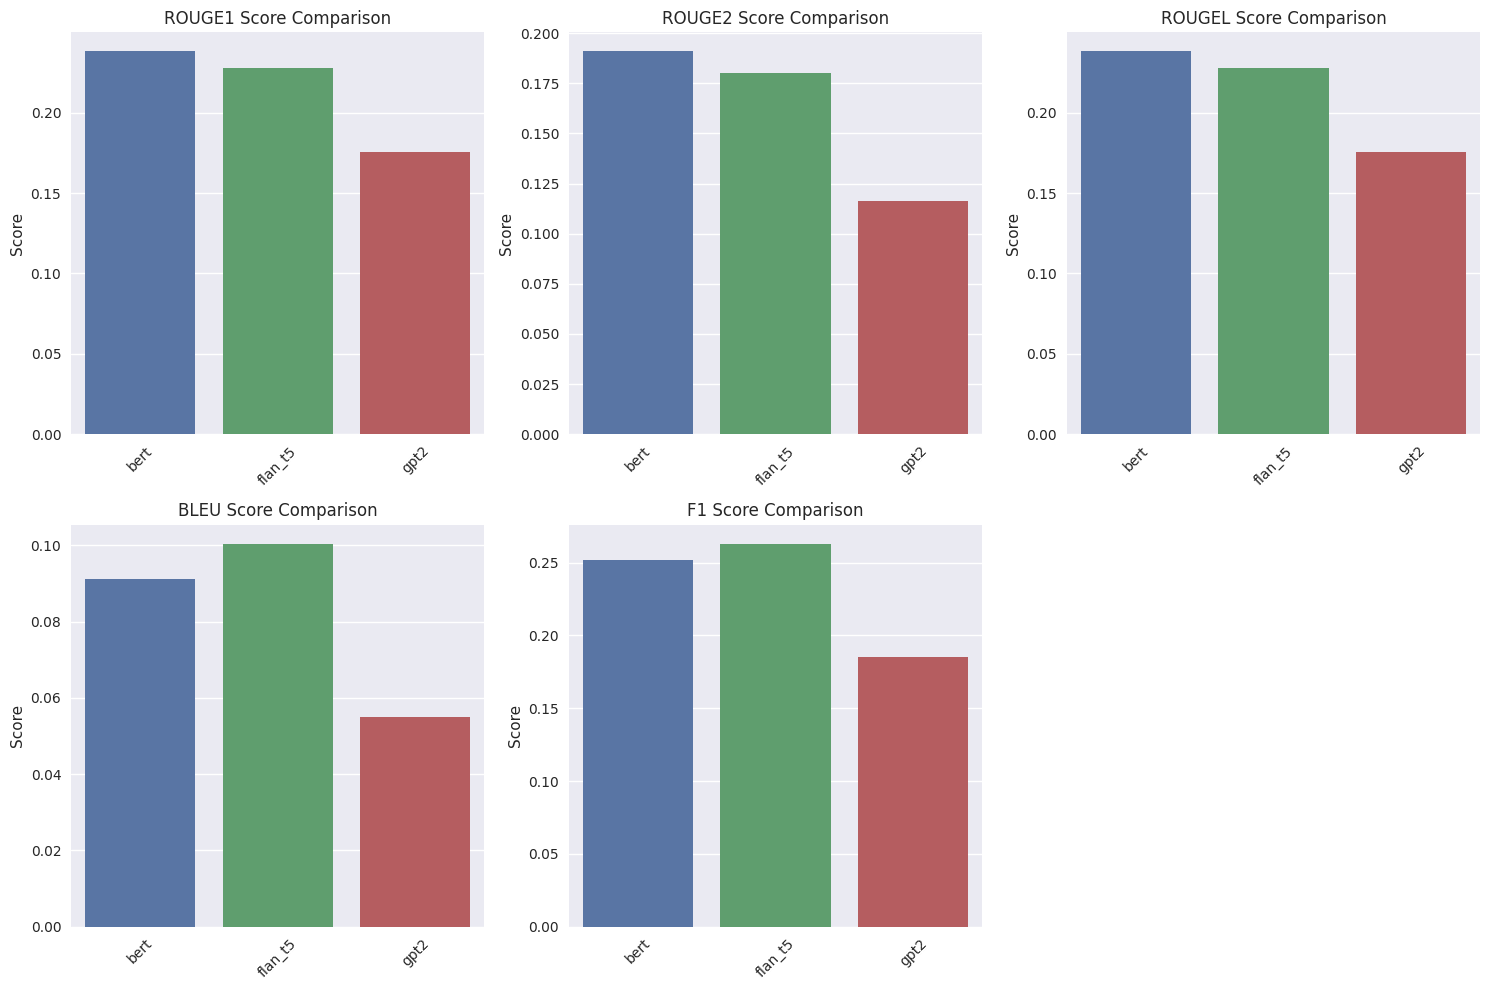

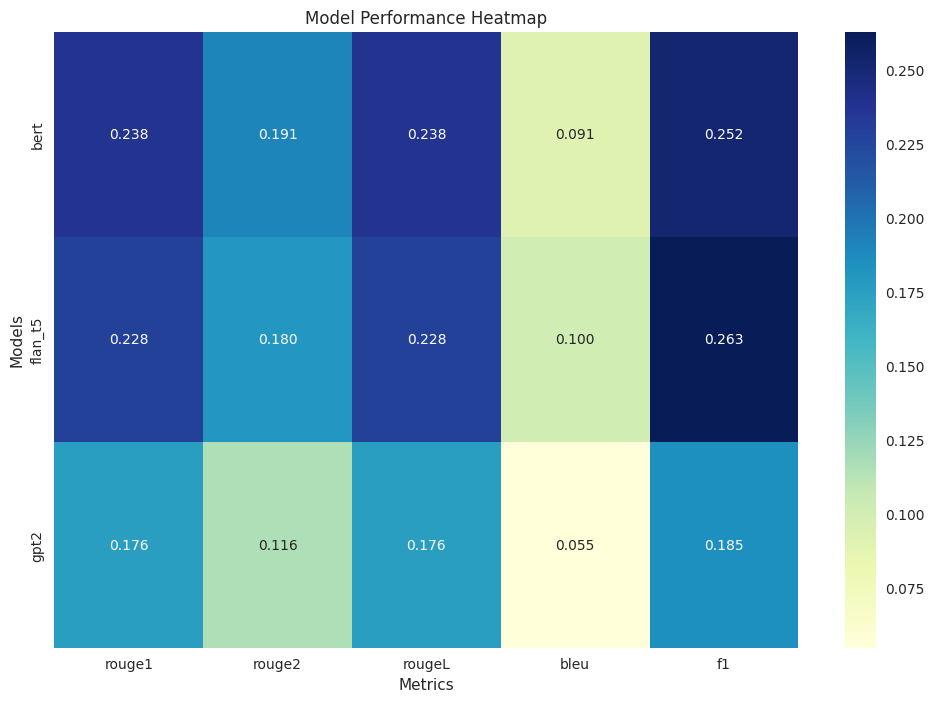

In [8]:
# For better-looking plots
plt.style.use('seaborn')

# Model Performance Comparison
model_names = list(all_metrics.keys())
metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'f1']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    values = [all_metrics[model][metric] for model in model_names]
    sns.barplot(x=model_names, y=values)
    plt.title(f'{metric.upper()} Score Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Heatmap of Model Performance
heatmap_data = pd.DataFrame(all_metrics).T

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Performance Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

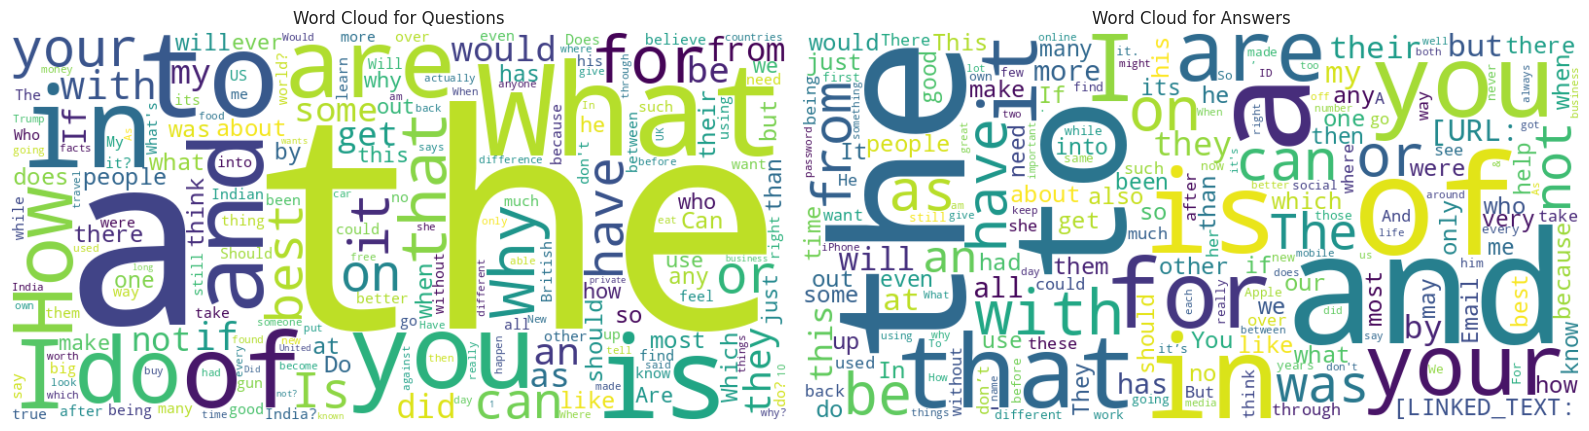

In [9]:
# Feature Importance
from collections import Counter
from wordcloud import WordCloud

# Combining all questions and answers into one string
all_questions = ' '.join(df['question'])
all_answers = ' '.join(df['answer'])

# Generating word frequencies
question_word_freq = Counter(all_questions.split())
answer_word_freq = Counter(all_answers.split())

# Generating word clouds
question_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(question_word_freq)
answer_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(answer_word_freq)

# Plotting the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(question_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def answer_question_ensemble(question, context, weights=[0.6, 0.4]):
    # Get answers from both models
    bert_result = pipelines['bert'](question=question, context=context)
    flan_t5_result = pipelines['flan_t5'](question=question, context=context)
    
    # Combine scores using weighted voting
    bert_score = bert_result['score'] * weights[0]
    flan_t5_score = flan_t5_result['score'] * weights[1]
    
    # Choose the answer with the highest weighted score
    if bert_score > flan_t5_score:
        return bert_result['answer']
    else:
        return flan_t5_result['answer']

# Evaluating the ensemble model
def evaluate_ensemble_model(df, weights=[0.6, 0.4]):
    def get_ensemble_answer(row):
        if not row['answer']:
            return "No answer available"
        return answer_question_ensemble(row['question'], row['answer'], weights=weights)
    
    df['ensemble_predicted_answer'] = df.apply(get_ensemble_answer, axis=1)
    
    metrics = df.apply(lambda x: calculate_metrics(x['answer'], x['ensemble_predicted_answer']), axis=1)
    metrics_df = pd.DataFrame(metrics.tolist())
    average_scores = metrics_df.mean()
    return average_scores

ensemble_metrics = evaluate_ensemble_model(df)

# Print average scores for the ensemble model
print("Ensemble Model:")
print("Average ROUGE-1 Score:", ensemble_metrics['rouge1'])
print("Average ROUGE-2 Score:", ensemble_metrics['rouge2'])
print("Average ROUGE-L Score:", ensemble_metrics['rougeL'])
print("Average BLEU Score:", ensemble_metrics['bleu'])
print("Average F1 Score:", ensemble_metrics['f1'])